In [1]:
import turicreate as tc
import pandas as pd
import numpy as np

In [2]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw.remove_column('fcount', inplace=True)

apk,function
5868,124151
38,205926
3965,412019
4227,455698
8365,89728
16611,673605
17213,507119
33,204076
497,342467
8526,204076


In [3]:
apks = mw['apk'].unique()
k = apks.shape[0]

In [6]:
sim_recom = tc.item_similarity_recommender.create(mw, user_id='function', item_id='apk', similarity_type='jaccard', 
                                                  only_top_k=k, threshold=0.0, verbose=False)

In [7]:
items = sim_recom.get_similar_items(apks, k=k)

In [9]:
def d(a, b, items):
    return items[(items['apk']==a)&(items['similar']==b)]

In [10]:
# distance between a and b a as calculated by turi:
a = 8200
b = 11365
d(a, b, items)

apk,similar,score,rank
8200,11365,0.1666666865348816,1831


In [12]:
# manually calculated distance
a_funcs = set(rel[rel['apk']==a]['function'])
b_funcs = set(rel[rel['apk']==b]['function'])

In [13]:
a_funcs, b_funcs

({101925, 178583}, {65996, 101925, 178583, 207973, 342566})

In [14]:
len(a_funcs.intersection(b_funcs))/len(a_funcs.union(b_funcs))

0.4

In [15]:
# does not help to calculate similarity only to one apk
i8 = sim_recom.get_similar_items([8200], k=k)
i8[i8['similar']==b]

apk,similar,score,rank
8200,11365,0.1666666865348816,1831


In [39]:
# playing with some parameters: no fixes found? 
#seed_item_set_size = 0 
#nearest_neighbors_interaction_proportion_threshold = 0.9
#degree_approximation_threshold 
sim_recom = tc.item_similarity_recommender.create(mw, user_id='function', item_id='apk', similarity_type='jaccard', 
                                                  only_top_k=k,nearest_neighbors_interaction_proportion_threshold=1, threshold=0.0, verbose=False)
it = sim_recom.get_similar_items([a], k=k)
it[it['similar']==b]

apk,similar,score,rank
8200,11365,0.1666666865348816,1835


## Distance error 

In [4]:
import random
import matplotlib.pyplot as plt

In [5]:
m = pd.read_csv('../data/joined.csv', index_col='apn')
m['nf'] = m['nf'].apply(eval)

In [6]:
def jaccard(apid1: int, apid2: int, funcs) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    return 1 - len(p1 & p2)/len(p1|p2)

# good old panda based distance calculation:
distance = lambda x,y: jaccard(x, y, m['nf'])

In [70]:
def get_similars(data, apks, degree_approximation_threshold = 4096):
    k = apks.shape[0]
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                      user_id='function', 
                                                      item_id='apk', 
                                                      similarity_type='jaccard', 
                                                      only_top_k=k,
                                                      degree_approximation_threshold = degree_approximation_threshold,
                                                      threshold=0.0, verbose=False)
    
    return sim_recom.get_similar_items(apks, k=k)

In [30]:
def tc_dist(a, b, similars):
    res = similars[(similars['apk']==a)&(similars['similar']==b)]['score']
    return res

In [71]:
def get_pairs(n=1000):
    pairs = list()
    for _ in range(n):
        (a, b) = random.choices(apks, k=2)
        pairs.append((a,b))
    return pairs

In [72]:
def calculate_distances(pairs, similars):
    dsts = list()
    for (a,b) in pairs:
        dis = similars[(similars['apk']==b)&(similars['similar']==a)]
        d = distance(a, b)
        if any(dis):
            dsts.append((a,b, 1-dis[0]['score'],d, dis[0]['rank']))
    return dsts

In [74]:
pairs = get_pairs()
st, en = list(zip(*pairs))

In [75]:
similars = get_similars(data=mw, apks=apks, degree_approximation_threshold=4096)
dsts = calculate_distances(pairs, similars)
df = pd.DataFrame(dsts, columns=['a', 'b', 'dist_tc', 'dist_pd', 'rank'])
df['err'] = df.apply(lambda x: (x[3] - x[2])**2, axis=1)

similars = get_similars(data=mw, apks=apks, degree_approximation_threshold=5*4096)
dsts2 = calculate_distances(pairs, similars)
df2 = pd.DataFrame(dsts2, columns=['a', 'b', 'dist_tc', 'dist_pd', 'rank'])
df2['err'] = df2.apply(lambda x: (x[3] - x[2])**2, axis=1)


In [83]:
similars = get_similars(data=mw, apks=apks, degree_approximation_threshold=2*4096)
dsts3 = calculate_distances(pairs, similars)
df3 = pd.DataFrame(dsts3, columns=['a', 'b', 'dist_tc', 'dist_pd', 'rank'])
df3['err'] = df3.apply(lambda x: (x[3] - x[2])**2, axis=1)

In [84]:
errs = df.sort_values(by='err')['err']
errs2 = df2.sort_values(by='err')['err']
errs3 = df3.sort_values(by='err')['err']

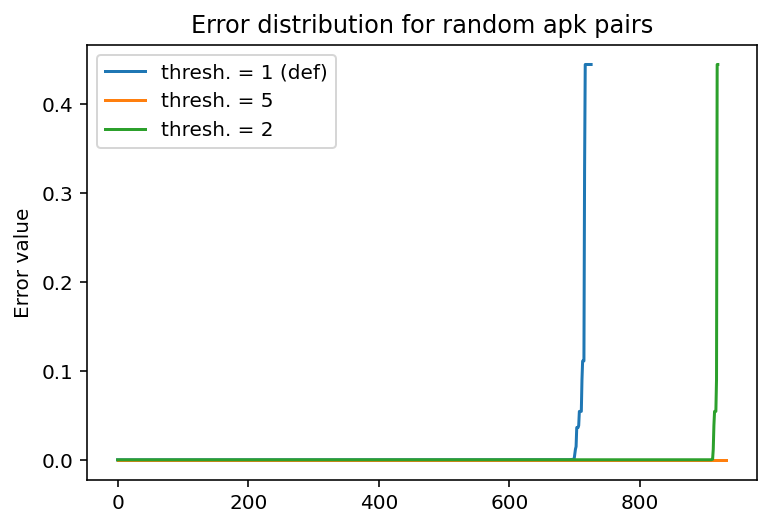

In [87]:
plt.title('Error distribution for random apk pairs')
plt.plot(range(0, len(errs)), errs, label='thresh. = 1 (def)')
plt.plot(range(0, len(errs2)), errs2, label='thresh. = 5')
plt.plot(range(0, len(errs3)), errs3, label='thresh. = 2')

plt.ylabel('Error value');
plt.legend();

In [88]:
df.to_csv('../res/distances-defaulttr.csv')
df2.to_csv('../res/distances-multiplethre.csv')
df3.to_csv('../res/distances-2trh.csv')

## what could be wrong?
1. size of the data matters (larger is better?)
1. correlation between rank and error?
1. correlation between size of function set and error? 

In [27]:
def get_similars(data, apks, k=None):
    if not k:
        k = len(apks)
        
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                  user_id='function', 
                                                  item_id='apk', 
                                                  similarity_type='jaccard', 
                                                  only_top_k=k,
                                                  threshold=0.0, verbose=False)
    return sim_recom.get_similar_items(apks, k=k)

In [39]:
def get_tc(a, b, similars):
    res = similars[(similars['apk']==a)&(similars['similar']==b)]
    return res

In [53]:
from collections import defaultdict

In [57]:
distances = defaultdict(list)
a = 8200
b = 11365
for r in range(3):
    for size in [100, 200, 400, 1000,2000, 5000]:
        sample = random.sample(list(apks), k=size)
        sample.extend([a,b])

        fu = mw.filter_by(values=sample, column_name='apk')
        sims = get_similars(data=fu, apks=sample)

        res = get_tc(a=a, b=b, similars=sims)
        if any(res):
            distances[size].extend([res[0]['score'], res[0]['rank'],fu.shape[0]])
        


In [58]:
distances

defaultdict(list,
            {100: [0.3999999761581421,
              17,
              377038,
              0.3999999761581421,
              14,
              399555,
              0.3999999761581421,
              30,
              381147],
             200: [0.3999999761581421,
              44,
              701794,
              0.3999999761581421,
              43,
              653501,
              0.3999999761581421,
              49,
              704987],
             400: [0.3999999761581421,
              81,
              1308658,
              0.3999999761581421,
              78,
              1380126,
              0.3999999761581421,
              79,
              1325203],
             1000: [0.3999999761581421,
              178,
              3167936,
              0.3999999761581421,
              162,
              3785860,
              0.3999999761581421,
              169,
              3610274],
             2000: [0.3999999761581421,
              356,
 

In [60]:
pd.DataFrame.from_dict(distances, orient='index')

,0,1,2,3,4,5,6,7,8
100,0.400000,17,377038,0.4,14,399555,0.4,30,381147
200,0.400000,44,701794,0.4,43,653501,0.4,49,704987
400,0.400000,81,1308658,0.4,78,1380126,0.4,79,1325203
1000,0.400000,178,3167936,0.4,162,3785860,0.4,169,3610274
2000,0.400000,356,7472307,0.4,341,7381645,0.4,360,7231569
5000,0.166667,1249,18132449,0.4,824,17061487,0.4,885,17472204


In [63]:
# playing with some parameters: no fixes found? 
#seed_item_set_size = 0 
#nearest_neighbors_interaction_proportion_threshold = 0.9
#degree_approximation_threshold 
#max_data_passes = (Default = 1024)
#degree_approximation_threshold (Default = 4096) 
#"Users with more than this many item interactions may be approximated. "
# -in our case users are functions
sim_recom = tc.item_similarity_recommender.create(mw, user_id='function', 
                                                  item_id='apk', 
                                                  similarity_type='jaccard', 
                                                  only_top_k=k,
                                                  nearest_neighbors_interaction_proportion_threshold=1, 
                                                  #max_data_passes = 5*1024,
                                                  degree_approximation_threshold = 5 * 4096,
                                                  threshold=0.0, verbose=False)
it = sim_recom.get_similar_items(apks, k=k)
it[it['similar']==b]

apk,similar,score,rank
8200,11365,0.3999999761581421,1671


In [66]:
it = sim_recom.get_similar_items(apks, k=k)
it[(it['similar']==b)&(it['apk']==a)]

apk,similar,score,rank
8200,11365,0.3999999761581421,1671


## verification of 15*496

In [35]:
import pickle
from tqdm.notebook import tqdm

def check_net(net, gamma, distance):
    mismatched = []
    keys = list(net.keys())
    for i,j in enumerate(keys):
        for m in keys[i+1:]:
            if (m!=j) and ((d:=distance(m, j))<gamma):
                #print(i, j, d)
                mismatched.append((m,j))
    return mismatched

In [32]:
net_file = '../res/9003-tc-jaccard-15-votingnets.pickle'
#old
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [39]:
def check_networks(nets):
    for gamma, [ref, mer] in tqdm(reversed(nets.items())):
        #print(gamma, len(ref), len(mer))
        res = check_net(net=ref, gamma=gamma, distance=distance)
        res2 = check_net(net=mer, gamma=gamma, distance=distance)
        print("%.2f"% gamma, len(res), len(res2))
        if gamma==0.5:
            break

In [40]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)
    
check_networks(nets)

0it [00:00, ?it/s]

1.00 0 18
0.94 0 48
0.89 0 63
0.83 0 52
0.78 0 66
0.72 0 50
0.67 0 139
0.61 0 152
0.56 0 137
0.50 0 163


In [ ]:
net_file =  '../res/9003-tc-jaccard-15-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)
    
check_networks(nets)

0it [00:00, ?it/s]

1.00 0 0
0.94 0 0
0.89 0 0
0.83 0 0
0.78 0 0
0.72 0 0
0.67 0 0
0.61 0 0
0.56 0 0


In [ ]:
net_file =  '../res/9003-tc-jaccard-5-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)
    
check_networks(nets)